
IT24103021 - Random Forest Regressor


In [1]:
# 1. Import and Setup
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
# 2. Load and Prepare Data 

df = pd.read_csv("../data/final_output.csv")
print("Data loaded successfully!")
print("Shape:", df.shape)

print("\nFirst few rows:")
df.head()


Data loaded successfully!
Shape: (3063, 11)

First few rows:


,car_age,year,owner,km_driven,brand_name_Mahindra,brand_name_Tata,brand_name_Toyota,brand_popularity,brand_name_Honda,brand_name_Chevrolet,selling_price
0,0.684211,0.315789,0,0.421683,0.0,0.0,0.0,1.000000,0.0,0.0,60000.000000
1,0.684211,0.315789,0,0.301201,0.0,0.0,0.0,1.000000,0.0,0.0,504355.832295
2,0.421053,0.578947,0,0.602407,0.0,0.0,0.0,0.578947,0.0,0.0,600000.000000
3,0.157895,0.842105,0,0.277104,0.0,0.0,0.0,0.026316,0.0,0.0,250000.000000
4,0.315789,0.684211,2,0.849397,0.0,0.0,0.0,0.188259,1.0,0.0,450000.000000


In [3]:
#  Split Features and Target 
X = df.drop(columns=["selling_price"]) # Input features
y = df["selling_price"]                # Target variable

numeric_cols = X.columns.tolist()      # Get all numeric column names

In [4]:
# 3. Data Preprocessing 
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols)
])

In [5]:
# 4. Split the Data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# 5. Cross-Validation Setup
cv = KFold(n_splits=5, shuffle=True, random_state=42) # 5-fold cross-validation

In [6]:
# Make Results Folders
os.makedirs("../results/outputs", exist_ok=True)
os.makedirs("../results/eda_visualizations", exist_ok=True)

results = []

In [7]:
# 6. Model 1: Base Random Forest
print("\nTraining Base Random Forest.")
base_model = Pipeline([
    ("preproc", preprocessor),
    ("rf", RandomForestRegressor(random_state=42))
])
base_model.fit(X_train, y_train)

# Evaluate performance
y_pred_base = base_model.predict(X_test)
r2_base = r2_score(y_test, y_pred_base)
mae_base = mean_absolute_error(y_test, y_pred_base)

r2_cv_base = cross_val_score(base_model, X_train, y_train, cv=cv, scoring="r2")
mae_cv_base = -cross_val_score(base_model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error")

print(f"Base RF - Test R²: {r2_base:.4f}, Test MAE: {mae_base:.2f}")
print(f"Base RF - CV R² Mean: {r2_cv_base.mean():.4f}, CV MAE Mean: {mae_cv_base.mean():.2f}")

# Save results
results.append({
    "model": "Base_RF",
    "test_r2": round(r2_base, 4),
    "test_mae": round(mae_base, 2),
    "cv_r2_mean": round(r2_cv_base.mean(), 4),
    "cv_mae_mean": round(mae_cv_base.mean(), 2)
})


Training Base Random Forest.
Base RF - Test R²: 0.4786, Test MAE: 129551.68
Base RF - CV R² Mean: 0.5135, CV MAE Mean: 122620.98


In [8]:
# 7. Model 2: Tuned Random Forest with GridSearchCV
print("\nTuning Random Forest with GridSearchCV.")
tuned_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("rf", RandomForestRegressor(random_state=42))
])

# Define parameter grid for tuning
param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5],
    "rf__max_features": ["sqrt", 0.8]
}

# Perform grid search with 5-fold CV
gscv = GridSearchCV(tuned_pipeline, param_grid, cv=cv, scoring="r2", n_jobs=-1)
gscv.fit(X_train, y_train)
print("Best parameters:", gscv.best_params_)

tuned_model = gscv.best_estimator_
y_pred_tuned = tuned_model.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

r2_cv_tuned = cross_val_score(tuned_model, X_train, y_train, cv=cv, scoring="r2")
mae_cv_tuned = -cross_val_score(tuned_model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error")

print(f"Tuned RF - Test R²: {r2_tuned:.4f}, Test MAE: {mae_tuned:.2f}")
print(f"Tuned RF - CV R² Mean: {r2_cv_tuned.mean():.4f}, CV MAE Mean: {mae_cv_tuned.mean():.2f}")

# Save results
results.append({
    "model": "Tuned_RF",
    "test_r2": round(r2_tuned, 4),
    "test_mae": round(mae_tuned, 2),
    "cv_r2_mean": round(r2_cv_tuned.mean(), 4),
    "cv_mae_mean": round(mae_cv_tuned.mean(), 2)
})


Tuning Random Forest with GridSearchCV.
Best parameters: {'rf__max_depth': 10, 'rf__max_features': 0.8, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Tuned RF - Test R²: 0.5546, Test MAE: 121395.79
Tuned RF - CV R² Mean: 0.5724, CV MAE Mean: 116025.75


In [9]:
# 8. Model 3: PCA (95%) + Tuned Random Forest
print("\nTraining PCA (95%) + Tuned Random Forest.")
pca_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("pca", PCA(n_components=0.95, svd_solver="full")),
    ("rf", RandomForestRegressor(random_state=42))
])

param_grid_pca = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10],
    "rf__max_features": ["sqrt", 0.8]
}

# Tune Random Forest with PCA
gscv_pca = GridSearchCV(pca_pipeline, param_grid_pca, cv=cv, scoring="r2", n_jobs=-1)
gscv_pca.fit(X_train, y_train)
print("PCA best parameters:", gscv_pca.best_params_)

# Evaluate PCA + RF model
pca_model = gscv_pca.best_estimator_
y_pred_pca = pca_model.predict(X_test)
r2_pca = r2_score(y_test, y_pred_pca)
mae_pca = mean_absolute_error(y_test, y_pred_pca)

r2_cv_pca = cross_val_score(pca_model, X_train, y_train, cv=cv, scoring="r2")
mae_cv_pca = -cross_val_score(pca_model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error")

print(f"PCA + Tuned RF - Test R²: {r2_pca:.4f}, Test MAE: {mae_pca:.2f}")
print(f"PCA + Tuned RF - CV R² Mean: {r2_cv_pca.mean():.4f}, CV MAE Mean: {mae_cv_pca.mean():.2f}")

# Save results
results.append({
    "model": "PCA_Tuned_RF",
    "test_r2": round(r2_pca, 4),
    "test_mae": round(mae_pca, 2),
    "cv_r2_mean": round(r2_cv_pca.mean(), 4),
    "cv_mae_mean": round(mae_cv_pca.mean(), 2)
})


Training PCA (95%) + Tuned Random Forest.


/Users/sujana/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/sujana/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/sujana/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/sujana/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/sujana/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/sujana/Library/Python/3.9/lib/python/site-packages/sklearn/decompo

PCA best parameters: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
PCA + Tuned RF - Test R²: 0.5411, Test MAE: 122571.15
PCA + Tuned RF - CV R² Mean: 0.5484, CV MAE Mean: 118580.78


In [10]:
# 9. Save Results
results_df = pd.DataFrame(results)
csv_path = "../results/outputs/IT24103021_rf_results.csv"
results_df.to_csv(csv_path, index=False)
print(results_df)

# Identify and save the best model
best_model_name = results_df.loc[results_df["test_r2"].idxmax(), "model"]
best_model = {
    "Base_RF": base_model,
    "Tuned_RF": tuned_model,
    "PCA_Tuned_RF": pca_model
}[best_model_name]


print(f" Best Model Selected: {best_model_name}")


          model  test_r2   test_mae  cv_r2_mean  cv_mae_mean
0       Base_RF   0.4786  129551.68      0.5135    122620.98
1      Tuned_RF   0.5546  121395.79      0.5724    116025.75
2  PCA_Tuned_RF   0.5411  122571.15      0.5484    118580.78
 Best Model Selected: Tuned_RF


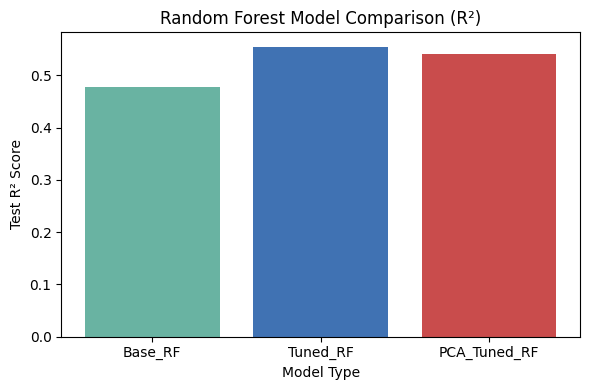

In [11]:
# 10. Visualization

plt.figure(figsize=(6, 4))
plt.bar(results_df["model"], results_df["test_r2"], color=["#69b3a2", "#4072b3", "#c94c4c"])
plt.title("Random Forest Model Comparison (R²)")
plt.ylabel("Test R² Score")
plt.xlabel("Model Type")
plt.tight_layout()

plot_path = "../results/eda_visualizations/IT24103021_rf_metrics_plot.png"
plt.savefig(plot_path)
plt.show()